# Data preparation 

Let's first only classify 30 dog breed from Standford dataset. 
Which are the one with the most images provided (number of images superior to the third inter-quartile)

https://www.youtube.com/watch?v=7Mv91hcxCCI&t=137s

In [217]:

%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import mlflow
# importing shutil module 
import shutil 
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
from common_params import data_dir, img_dir, npy_dir, MAX_NUMBER_CLASS, input_shape, image_size, IMG_SIZE, NB_AUGMENTATION
from common_plots import display_images, plot_img
from common_mlflow import save_experiment_mlflow
from data_load import get_train_val_set, apply_data_augmentation, delete_files_in_directory, copy_files_from_dir, prepare_subfolder_extract
from common_plots import plot_train_val_accuracy_and_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
print(tf.__version__)

2.8.3


### Load images 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

##  DATASET SUBSET

In [219]:
model_run_config = {
    "experiment_name" : "cnn-dog-breed-classifier",
    "batch_size" : 128,
    "NB_IMG_PER_CLASS" : 200 ,
    "NB_CLASS" : 10 ,
    "num_epochs" : 250 ,
    "input_shape" : input_shape,
    "optimizer" : "adam",
    "metrics" : ['accuracy'],
    "loss" : "categorical_crossentropy",
    "num_augmentations" : 10,
    "data_augmentation" : True
    
}

In [220]:

batch_size              =  model_run_config['batch_size']
NB_IMG_PER_CLASS        =  model_run_config["NB_IMG_PER_CLASS"]
NB_CLASS                =  model_run_config["NB_CLASS"]
num_epochs              =  model_run_config["num_epochs"]
experiment_name         =  model_run_config["experiment_name"]
optimizer               =  model_run_config["optimizer"]
metrics                 =  model_run_config["metrics"]
loss                    =  model_run_config["loss"]
num_augmentations       =  model_run_config["num_augmentations"]
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)

# Add : only take NB_CLASS classes

In [221]:
train_dir, test_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

In [222]:
train_ds, validation_ds, class_names = get_train_val_set(train_dir, image_size, batch_size)


Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Found 2000 files belonging to 10 classes.
Using 400 files for validation.


In [223]:
class_names

['n02085936-Maltese_dog',
 'n02086240-Shih-Tzu',
 'n02088094-Afghan_hound',
 'n02090721-Irish_wolfhound',
 'n02092002-Scottish_deerhound',
 'n02107683-Bernese_mountain_dog',
 'n02111129-Leonberg',
 'n02111500-Great_Pyrenees',
 'n02111889-Samoyed',
 'n02112018-Pomeranian']

<Figure size 700x700 with 0 Axes>

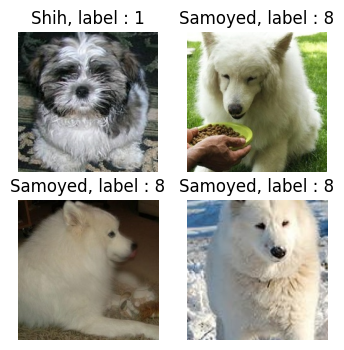

In [224]:
plt.figure(figsize=(7, 7))
img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

<Figure size 700x700 with 0 Axes>

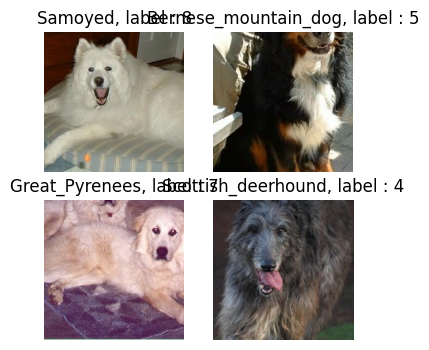

In [225]:
plt.figure(figsize=(7, 7))
img_list = []
titles = []
for images, labels in train_ds.take(1): # 1 batch
    for i in range(4): 
        img_list.append(images[i].numpy().astype("uint8"))
        idx = np.argmax(labels[i])
        titles.append(f"{class_names[idx].split('-')[1]}, label : {idx}")
display_images(img_list, 2, 2, from_path=False,titles=titles)

In [226]:
train_ds.cardinality().numpy() *32

416

# My convolutional neural network 

In [227]:
model_run_config["conv1_width"] =  16
model_run_config["conv2_width"] =  128
model_run_config["conv3_width"] =  256
# model_run_config["conv4_width"] =  256 

model_run_config["conv1_strides"] =  (2,2) 
model_run_config["conv1_kernel"] = (5,5)
model_run_config["conv1_pool_size"] =  (3,3) 
model_run_config["conv2_strides"] =  (2,2) 
model_run_config["conv2_pool_size"] =  (2,2) 
model_run_config["conv3_strides"] =  (2,2) 

model_run_config["dense1_size"] =  64
model_run_config["DropOut"] =  0.6
model_run_config["activation_last_layer"] =  'softmax'

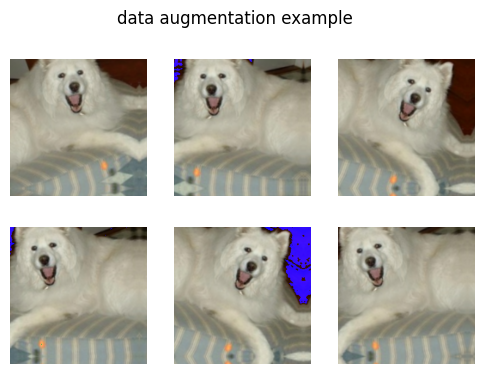

In [228]:
if model_run_config["data_augmentation"] :   
    
    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.RandomTranslation(height_factor=(-0.1, -0.1), width_factor=(-0.1, -0.1)),
            tf.keras.layers.RandomContrast(0.05),
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.1), width_factor=(-0.1, -0.1)),
        ])

    list_transform = [data_augmentation(tf.expand_dims(img_list[0], axis=0),training=True).numpy().astype("uint8")[0] for _ in range(NB_AUGMENTATION)]

    display_images(list_transform, 2, 3, from_path=False,main_title="data augmentation example")

In [229]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling

def get_personal_model():
    model = Sequential()
    
    model.add(Rescaling( 1.0 / 255 , input_shape=input_shape))
    
    if model_run_config["data_augmentation"] :   
        model.add(data_augmentation)

    model.add(Conv2D(model_run_config["conv1_width"], model_run_config["conv1_kernel"], activation='relu')) # kernel = 3*3
    model.add(MaxPooling2D(model_run_config["conv1_pool_size"], strides=model_run_config["conv1_strides"] ,padding="same"))
    
    model.add(Conv2D(model_run_config["conv2_width"] , (3, 3), activation='relu', strides=model_run_config["conv2_strides"] ))
    model.add(MaxPooling2D(model_run_config["conv2_pool_size"]))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(model_run_config["conv3_width"] , (3, 3), activation='relu', strides=model_run_config["conv3_strides"] ))
    model.add(MaxPooling2D((2, 2)))
    
    # model.add(Conv2D(model_run_config["conv4_width"] , (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(model_run_config["dense1_size"], activation='relu'))
    
    model.add(Dropout(model_run_config["DropOut"]))
    model.add(Dense(NB_CLASS, activation=model_run_config["activation_last_layer"]))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model 

In [230]:
cnn_based_model = get_personal_model()

In [231]:
cnn_based_model.build(input_shape)

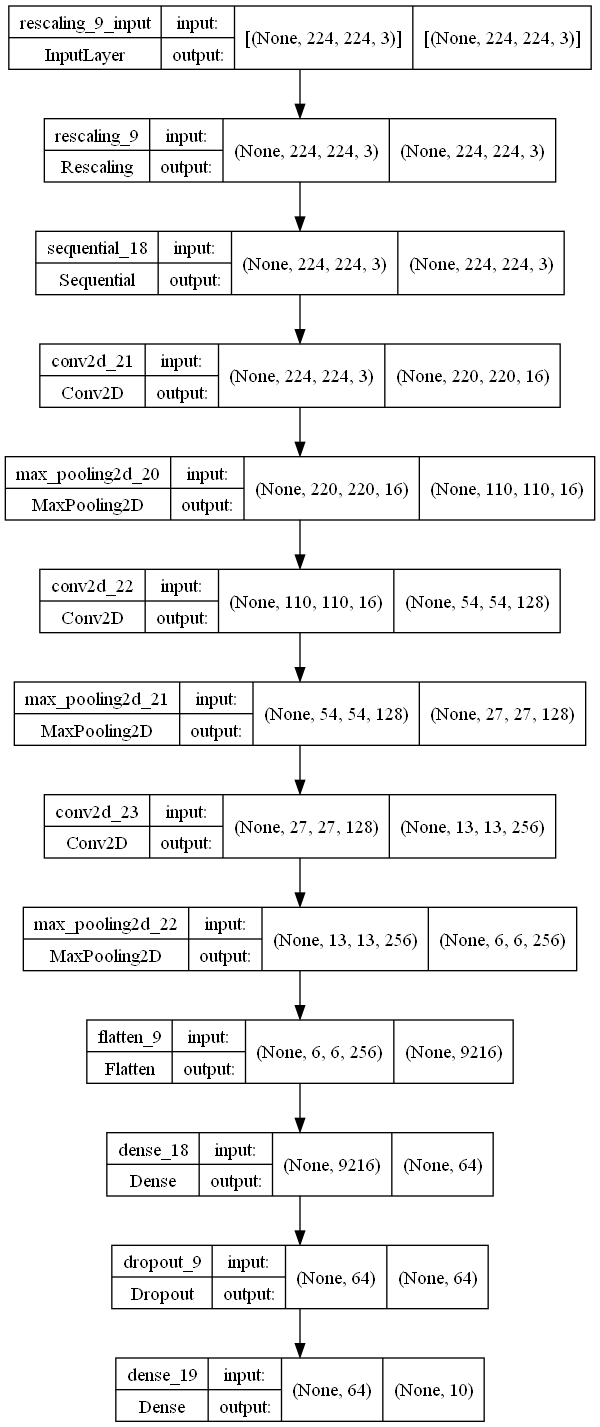

In [232]:
tf.keras.utils.plot_model(cnn_based_model, show_shapes=True)

In [233]:
cnn_based_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 54, 54, 128)       18560     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 27, 27, 128)      0         
 g2D)                                                

In [234]:

run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tb_callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)]


In [235]:
os.path.isdir(logdir)

False

In [236]:
history = cnn_based_model.fit(
    train_ds,
    epochs=num_epochs,
    callbacks=tb_callback,
    validation_data=validation_ds)

Epoch 1/150
13/13 [==============================] - 29s 2s/step - loss: 2.2936 - accuracy: 0.1275 - val_loss: 2.2277 - val_accuracy: 0.1800
Epoch 2/150
13/13 [==============================] - 23s 2s/step - loss: 2.2345 - accuracy: 0.1612 - val_loss: 2.1669 - val_accuracy: 0.1850
Epoch 3/150
13/13 [==============================] - 22s 2s/step - loss: 2.1651 - accuracy: 0.2075 - val_loss: 2.0994 - val_accuracy: 0.1950
Epoch 4/150
13/13 [==============================] - 24s 2s/step - loss: 2.1151 - accuracy: 0.2256 - val_loss: 2.0989 - val_accuracy: 0.2275
Epoch 5/150
13/13 [==============================] - 26s 2s/step - loss: 2.0685 - accuracy: 0.2500 - val_loss: 2.1037 - val_accuracy: 0.2450
Epoch 6/150
13/13 [==============================] - 28s 2s/step - loss: 2.0476 - accuracy: 0.2644 - val_loss: 2.0688 - val_accuracy: 0.2375
Epoch 7/150
13/13 [==============================] - 26s 2s/step - loss: 2.0412 - accuracy: 0.2731 - val_loss: 1.9944 - val_accuracy: 0.2925
Epoch 8/150
1

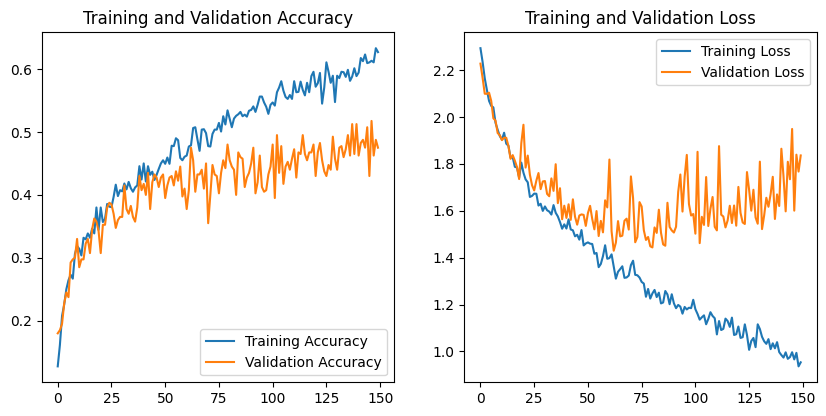

In [237]:
fig = plot_train_val_accuracy_and_loss(history, show=False)

In [238]:
mlflow_run_id = save_experiment_mlflow(cnn_based_model, model_run_config, run_name, history, fig=fig)

MLFlow Run ID:  b9567602f7a74211b75973ad8aabf08f
INFO:tensorflow:Assets written to: C:\Users\clara\AppData\Local\Temp\tmpb3xayhx6\model\data\model\assets


In [239]:
img_path = os.path.join(data_dir,"extracted\\test\\n02085936-Maltese_dog\\n02085936_1244_0.jpg")
img = tf.keras.utils.load_img(
    img_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = cnn_based_model.predict(img_array)[0]
print(predictions)


[4.7173119e-01 5.1639672e-02 2.1524522e-02 2.5409896e-02 2.1513902e-04
 4.1631083e-05 1.1516046e-03 2.2731695e-01 1.3897412e-01 6.1995272e-02]


In [240]:
class_names_from_folder = [ name.split('-')[1] for name in class_names ]
print(f"This image as a probability {round(100*predictions[0],2)}% {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

This image as a probability 47.17% Maltese_dog of and a probability 5.16% of Shih
